In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
input_length = 168
output_length = 24

show_graph = True

In [3]:
# Original Group

# model_paths = ["Save_File/Grouped_model_0601/A1.ckpt",
#                 "Save_File/Grouped_model_0601/A2.ckpt",
#                 "Save_File/Grouped_model_0601/A3.ckpt",
#                 "Save_File/Grouped_model_0601/A4.ckpt",
#                 "Save_File/Grouped_model_0601/B1.ckpt",
#                 "Save_File/Grouped_model_0601/B2.ckpt",
#                 "Save_File/Grouped_model_0601/B3.ckpt",
#                 "Save_File/Grouped_model_0601/B4.ckpt",
#                 "Save_File/Grouped_model_0601/C1.ckpt",
#                 "Save_File/Grouped_model_0601/C2.ckpt",
#                 "Save_File/Grouped_model_0601/C3.ckpt",
#                 "Save_File/Grouped_model_0601/C4.ckpt",
#                 "Save_File/Grouped_model_0601/D1.ckpt",
#                 "Save_File/Grouped_model_0601/D2.ckpt",
#                 "Save_File/Grouped_model_0601/D3.ckpt",
#                 "Save_File/Grouped_model_0601/D4.ckpt",
#                 "Save_File/Grouped_model_0601/D5.ckpt",
#                 "Save_File/Grouped_model_0601/E1.ckpt",
#                 "Save_File/Grouped_model_0601/E2.ckpt",
#                 "Save_File/Grouped_model_0601/E3.ckpt",
#                 "Save_File/Grouped_model_0601/E4.ckpt"]

# group_name = [
#     "A1", "A2", "A3", "A4", 
#     "B1", "B2", "B3", "B4",
#     "C1", "C2", "C3", "C4", 
#     "D1", "D2", "D3", "D4", "D5", 
#     "E1", "E2", "E3", "E4"
# ]

# group = [
#     [4],[10, 11, 12, 41],[34],[40, 42]
#     ,[6, 8, 13, 17, 25, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47]
#     ,[1, 31],[9, 32],[3],[33]
#     ,[2, 14, 22, 23, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45]
#     ,[5, 59],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60]
# ]

# data_path = "./Refined_Data/Grouped_Data/Input_Data.csv"

# Group 2

# model_paths = ["Save_File/Grouped2_model_0602/A1.ckpt",
#                 "Save_File/Grouped2_model_0602/A2.ckpt",
#                 "Save_File/Grouped2_model_0602/A3.ckpt",
#                 "Save_File/Grouped2_model_0602/A4.ckpt",
#                 "Save_File/Grouped2_model_0602/A5.ckpt",
#                 "Save_File/Grouped2_model_0602/A6.ckpt",
#                 "Save_File/Grouped2_model_0602/A7.ckpt",
#                 "Save_File/Grouped2_model_0602/B1.ckpt",
#                 "Save_File/Grouped2_model_0602/B2.ckpt",
#                 "Save_File/Grouped2_model_0602/B3.ckpt",
#                 "Save_File/Grouped2_model_0602/B4.ckpt",
#                 "Save_File/Grouped2_model_0602/B5.ckpt",
#                 "Save_File/Grouped2_model_0602/C1.ckpt",
#                 "Save_File/Grouped2_model_0602/C2.ckpt",
#                 "Save_File/Grouped2_model_0602/C3.ckpt",
#                 "Save_File/Grouped2_model_0602/C4.ckpt",
#                 "Save_File/Grouped2_model_0602/D1.ckpt",
#                 "Save_File/Grouped2_model_0602/D2.ckpt",
#                 "Save_File/Grouped2_model_0602/D3.ckpt",
#                 "Save_File/Grouped2_model_0602/D4.ckpt",
#                 "Save_File/Grouped2_model_0602/D5.ckpt",
#                 "Save_File/Grouped2_model_0602/D6.ckpt",
#                 "Save_File/Grouped2_model_0602/E1.ckpt",
#                 "Save_File/Grouped2_model_0602/E2.ckpt",
#                 "Save_File/Grouped2_model_0602/E3.ckpt",
#                 "Save_File/Grouped2_model_0602/E4.ckpt",
#                 "Save_File/Grouped2_model_0602/E5.ckpt"]

# individual experiment ~ing
model_paths = ["Save_File/experiment/A1/41.ckpt",
                "Save_File/Grouped2_model_0602/A2.ckpt",
                "Save_File/experiment/A3/3401.ckpt",
                "Save_File/experiment/A4/4001.ckpt",
                "Save_File/experiment/A5/1001.ckpt",
                "Save_File/experiment/A6/4216.ckpt",
                "Save_File/experiment/A7/4108.ckpt",
                "Save_File/Grouped2_model_0602/B1.ckpt",
                "Save_File/Grouped2_model_0602/B2.ckpt",
                "Save_File/Grouped2_model_0602/B3.ckpt",
                "Save_File/Grouped2_model_0602/B4.ckpt",
                "Save_File/Grouped2_model_0602/B5.ckpt",
                "Save_File/Grouped2_model_0602/C1.ckpt",
                "Save_File/Grouped2_model_0602/C2.ckpt",
                "Save_File/Grouped2_model_0602/C3.ckpt",
                "Save_File/Grouped2_model_0602/C4.ckpt",
                "Save_File/Grouped2_model_0602/D1.ckpt",
                "Save_File/Grouped2_model_0602/D2.ckpt",
                "Save_File/Grouped2_model_0602/D3.ckpt",
                "Save_File/Grouped2_model_0602/D4.ckpt",
                "Save_File/Grouped2_model_0602/D5.ckpt",
                "Save_File/Grouped2_model_0602/D6.ckpt",
                "Save_File/Grouped2_model_0602/E1.ckpt",
                "Save_File/Grouped2_model_0602/E2.ckpt",
                "Save_File/Grouped2_model_0602/E3.ckpt",
                "Save_File/Grouped2_model_0602/E4.ckpt",
                "Save_File/Grouped2_model_0602/E5.ckpt"]

group_name = [
    "A1", "A2", "A3", "A4", "A5", "A6", "A7",
    "B1", "B2", "B3", "B4", "B5",
    "C1", "C2", "C3", "C4", 
    "D1", "D2", "D3", "D4", "D5", "D6", 
    "E1", "E2", "E3", "E4", "E5"
]

group = [
    [4],[11, 12],[34],[40],[10],[42],[41]
    ,[6, 8, 13, 17, 26, 48, 53, 55, 56],[7, 18],[27, 57],[35, 46, 47],[25]
    ,[1, 31],[9, 32],[3],[33]
    ,[2, 14, 22, 37, 44, 52, 54],[15],[38, 58, 43],[29, 39],[45],[23]
    ,[5],[16, 24],[19, 20, 21, 49, 50, 51],[28, 30, 36, 60],[59]
]

data_path = "./Refined_Data/Grouped_Data/Input_Data2.csv"

In [4]:
dataframes = pd.read_csv(data_path, parse_dates = ["date_time"])

dataframes['num']     =   dataframes['num'].apply(str)
dataframes['Week']    =   dataframes['Week'].apply(str)
dataframes['24Hour']  =   dataframes['24Hour'].apply(str)
dataframes['holiday'] =   dataframes['holiday'].apply(str)
dataframes['Weekend'] =   dataframes['Weekend'].apply(str)
dataframes['energy_group'] = dataframes['energy_group'].apply(str)

random_choice = 2 # random.randrange(2,13)

start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

all_smape = []
part_smape = [[] for i in range(len(group_name))]

now group : A1


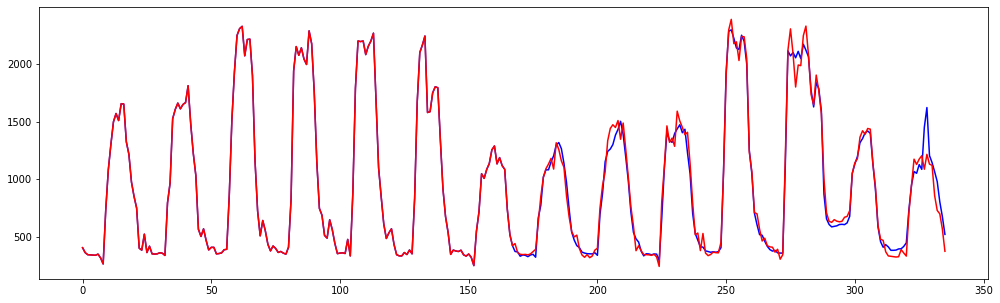

building : 4, score : 7.282060999405151
now group : A2


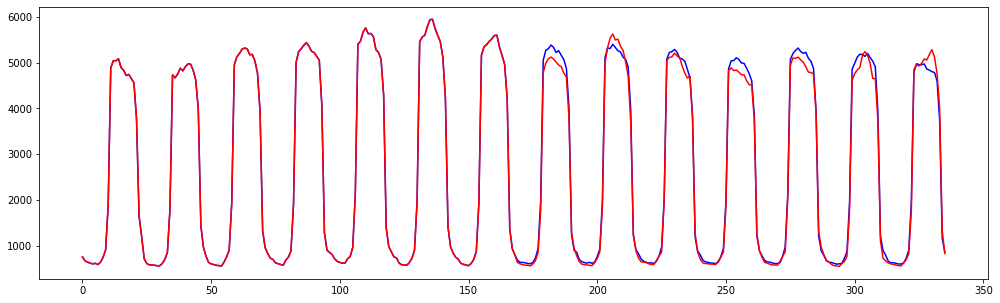

building : 11, score : 5.105898012715776


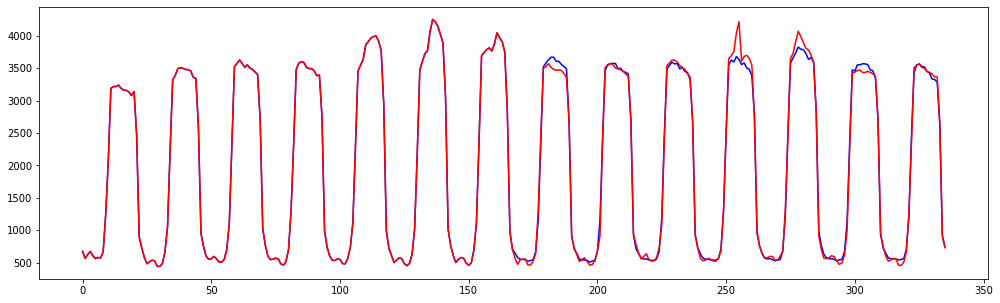

building : 12, score : 3.971013992287673
now group : A3


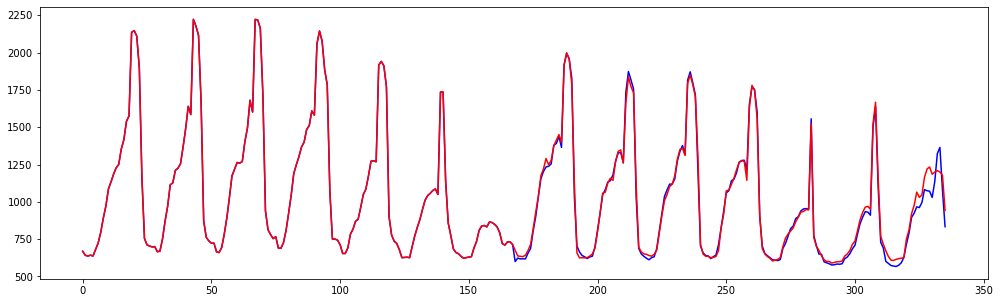

building : 34, score : 2.9296241266611007
now group : A4


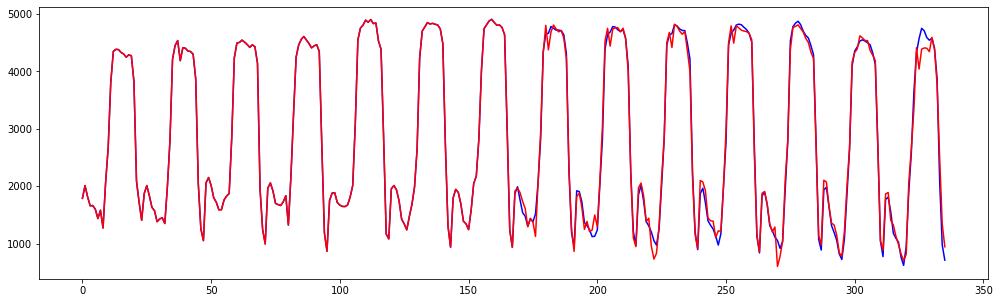

building : 40, score : 5.280621744978951
now group : A5


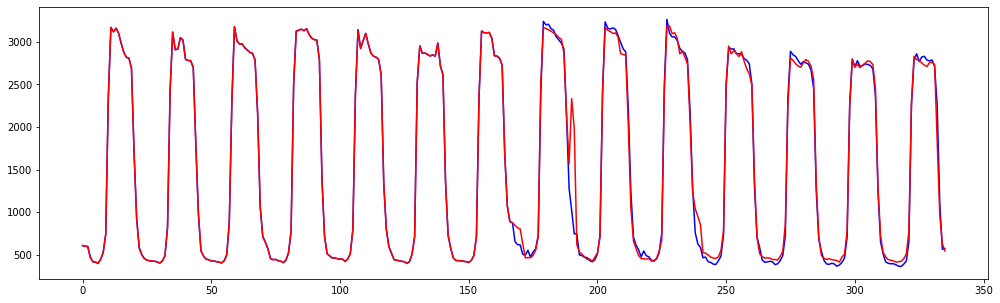

building : 10, score : 7.7592858763860235
now group : A6


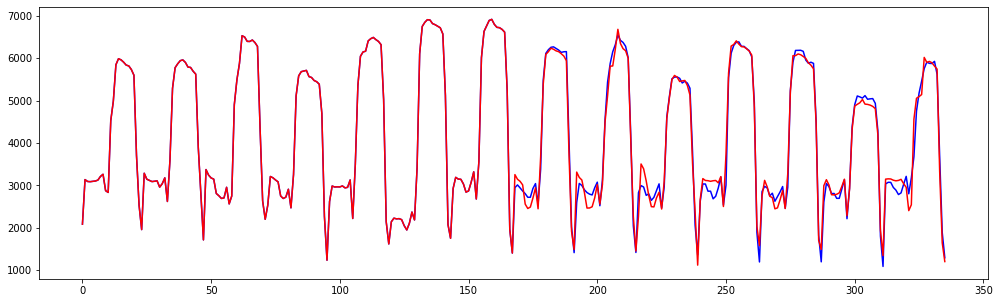

building : 42, score : 5.096037184454593
now group : A7


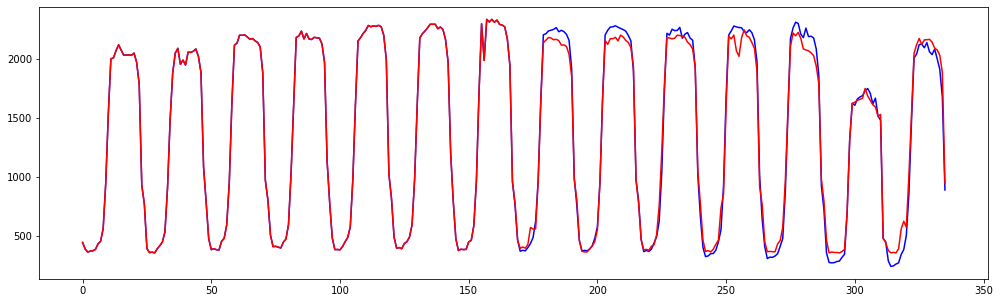

building : 41, score : 7.4440360662176035
now group : B1


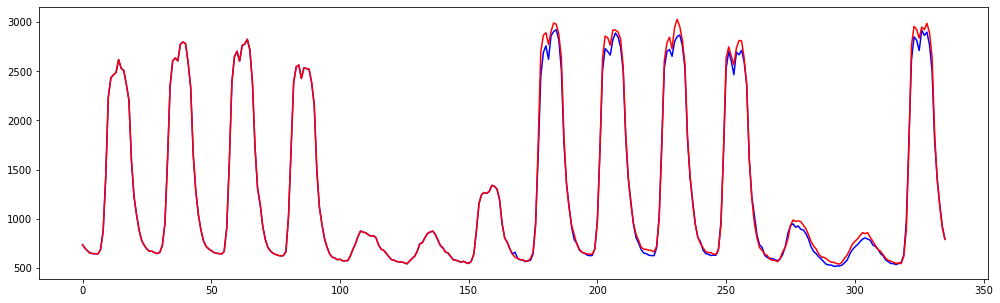

building : 6, score : 3.6143280526673682


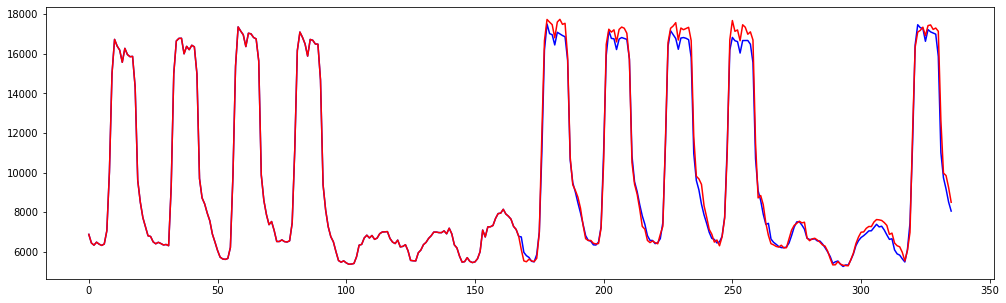

building : 8, score : 2.901211243885073


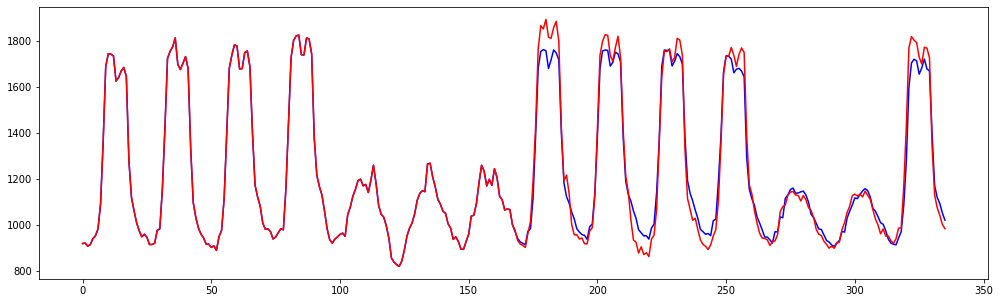

building : 13, score : 3.406637833969376


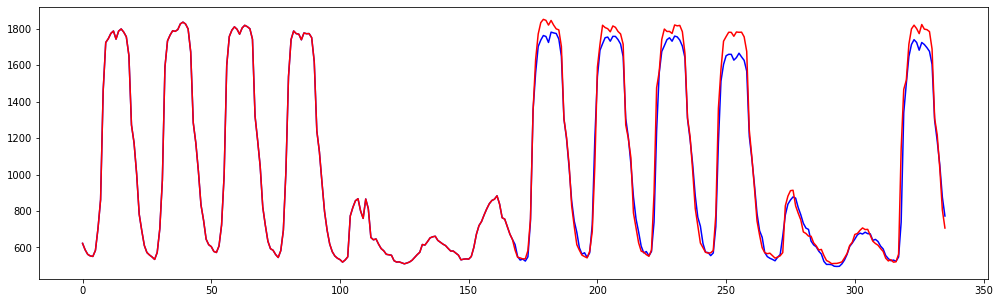

building : 17, score : 4.260659379908331


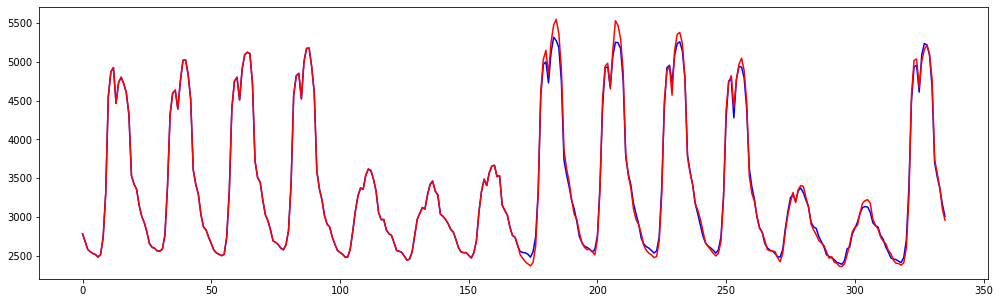

building : 26, score : 1.6223437807644423


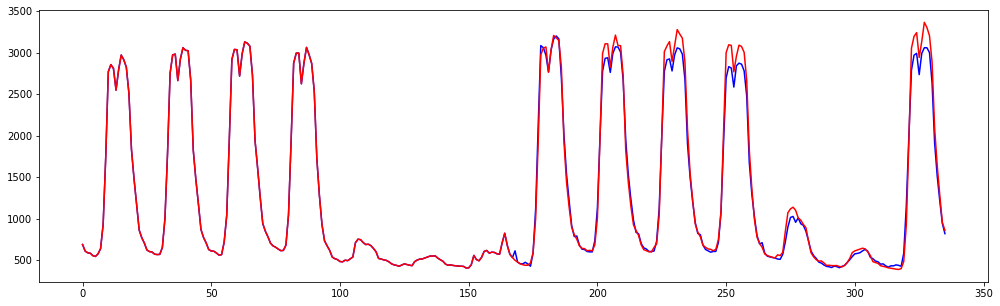

building : 48, score : 5.027862907103122


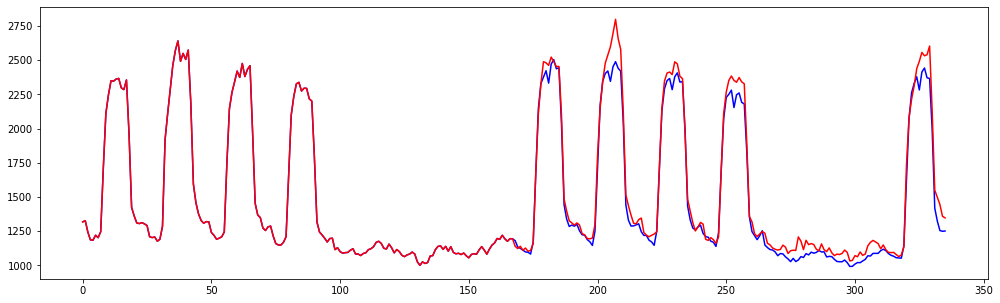

building : 53, score : 3.8285959216671324


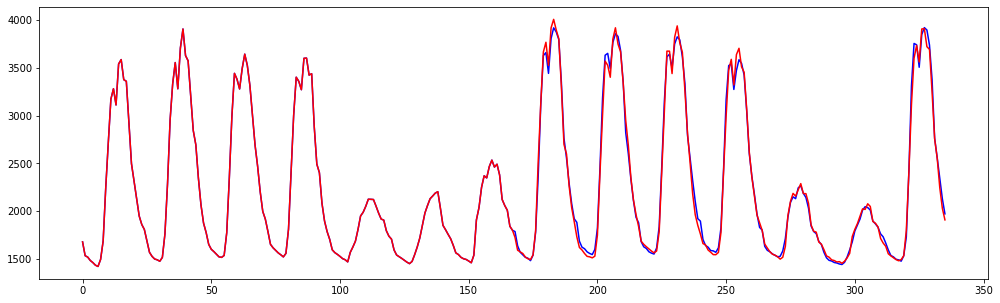

building : 55, score : 1.877389286738335


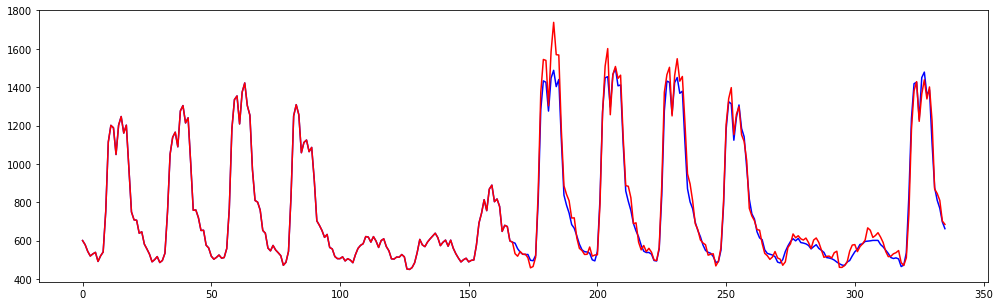

building : 56, score : 4.122845989573066
now group : B2


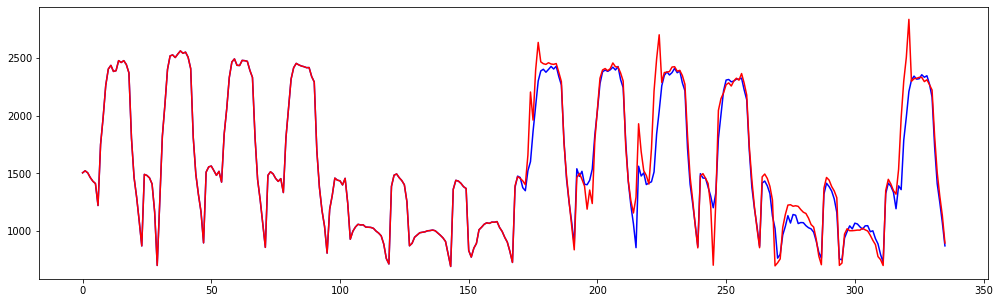

building : 7, score : 6.040614652595328


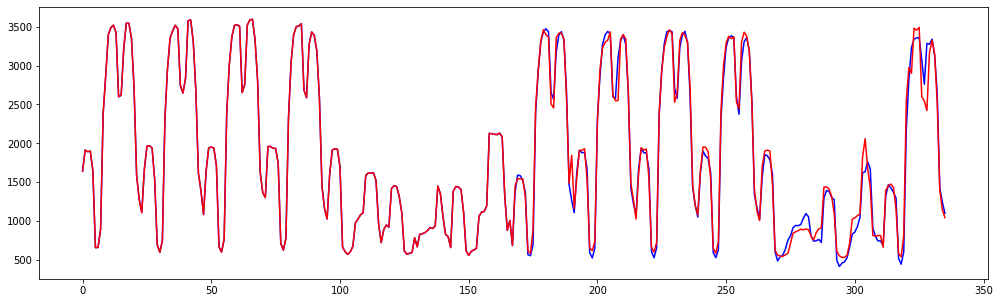

building : 18, score : 6.712253743896059
now group : B3


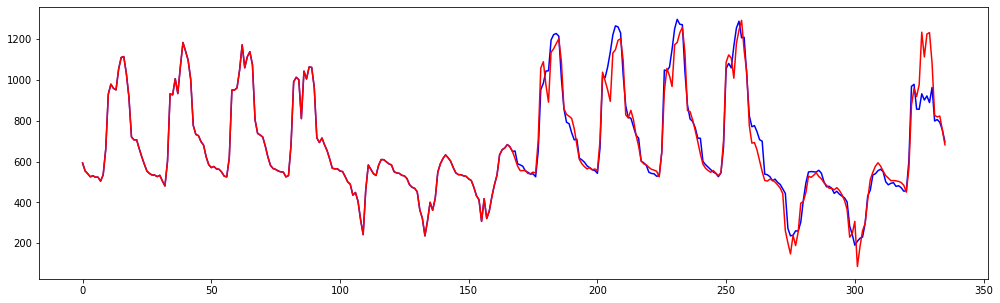

building : 27, score : 7.18658247784368


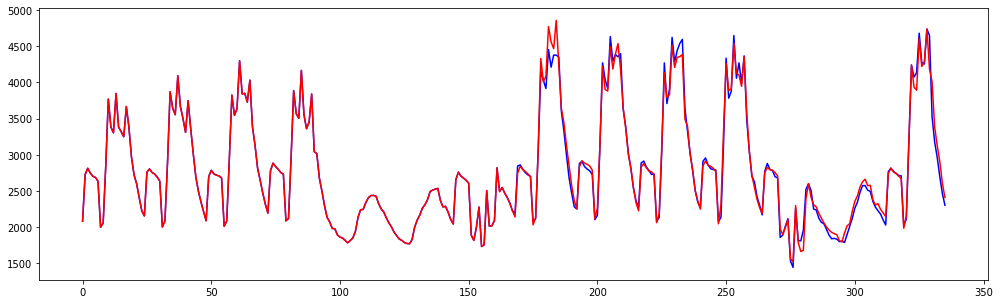

building : 57, score : 2.5450285124088676
now group : B4


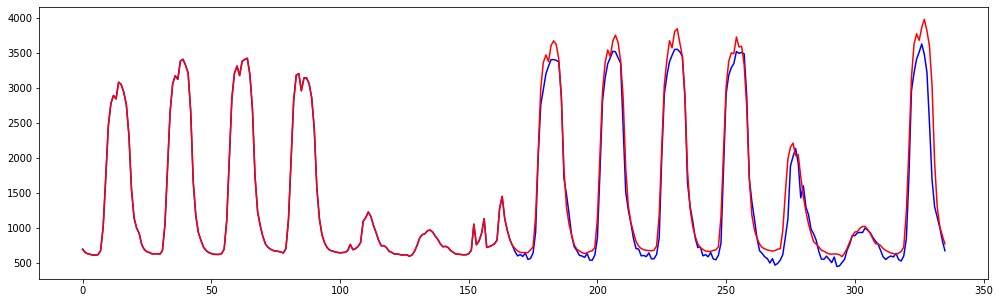

building : 35, score : 11.856222360093653


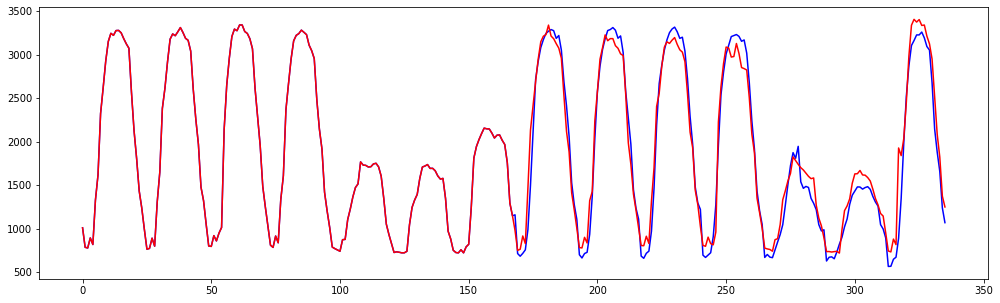

building : 46, score : 9.598646648900695


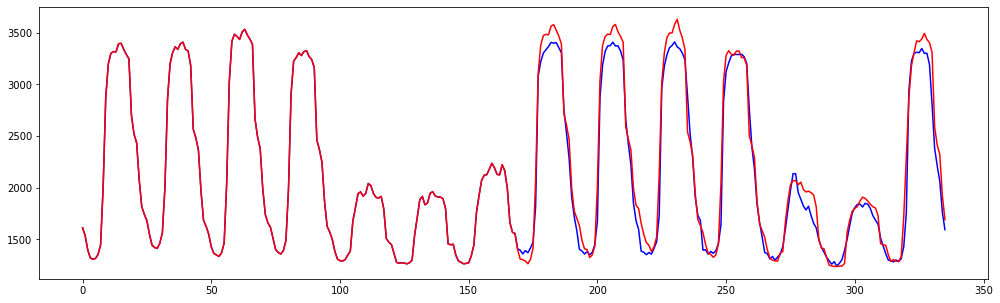

building : 47, score : 4.868310897064201
now group : B5


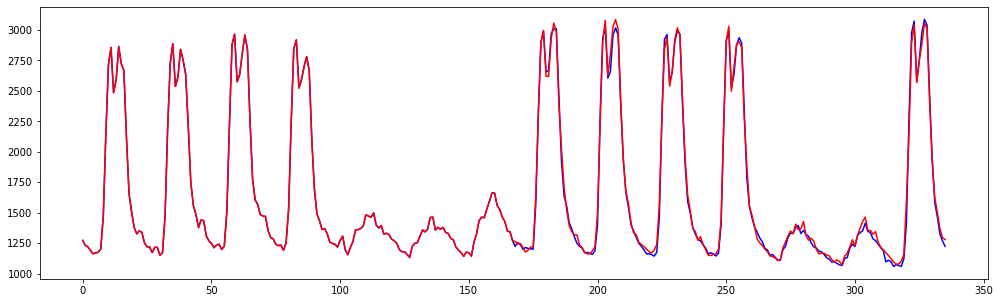

building : 25, score : 1.968324899378457
now group : C1


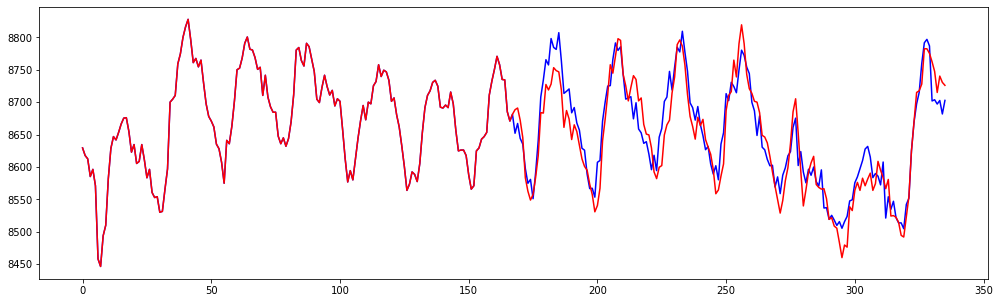

building : 1, score : 0.28685501308179334


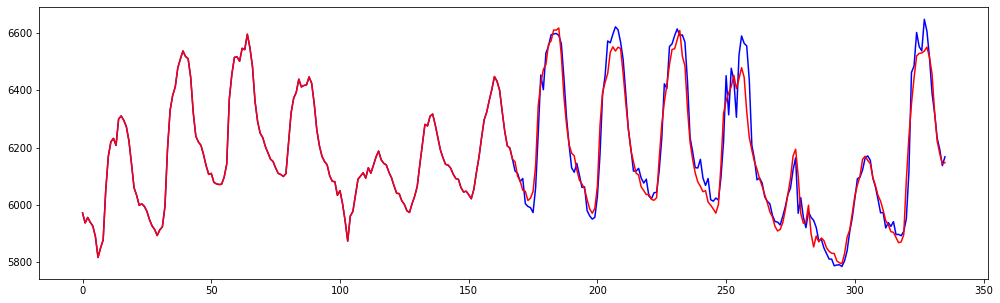

building : 31, score : 0.6093001983303199
now group : C2


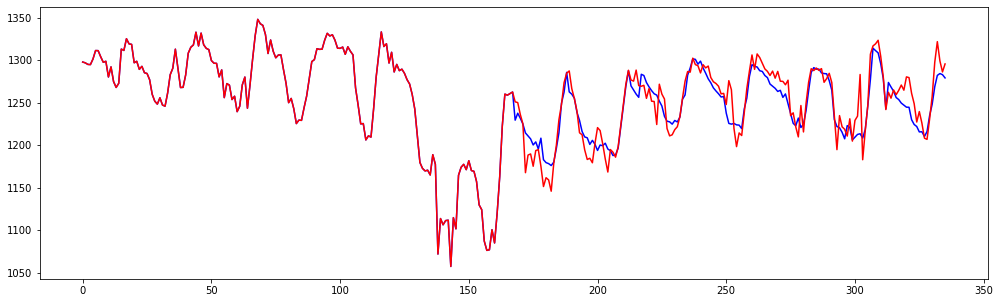

building : 9, score : 1.0251838790773402


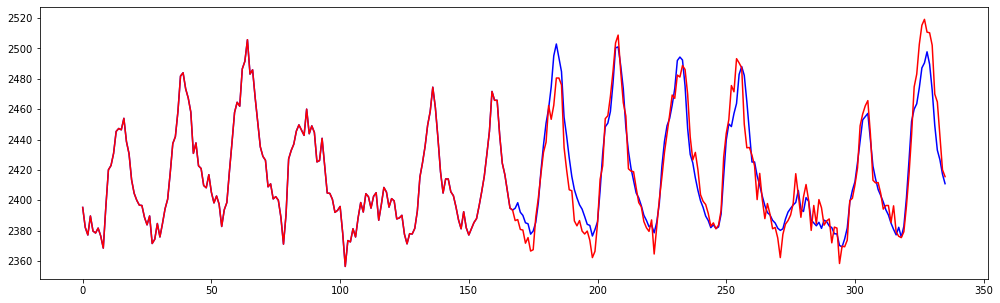

building : 32, score : 0.36963965991896297
now group : C3


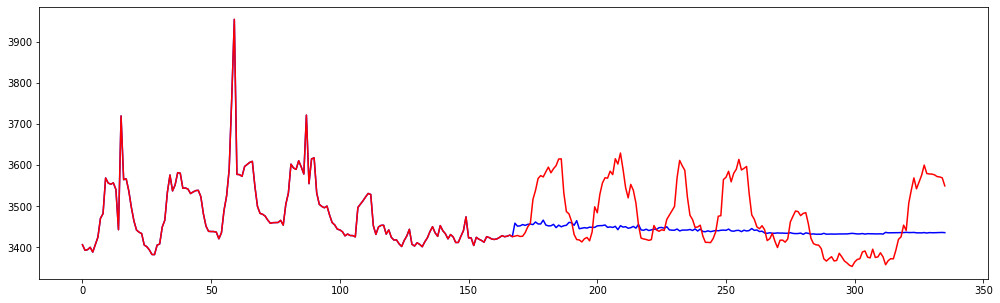

building : 3, score : 1.880216278609229
now group : C4


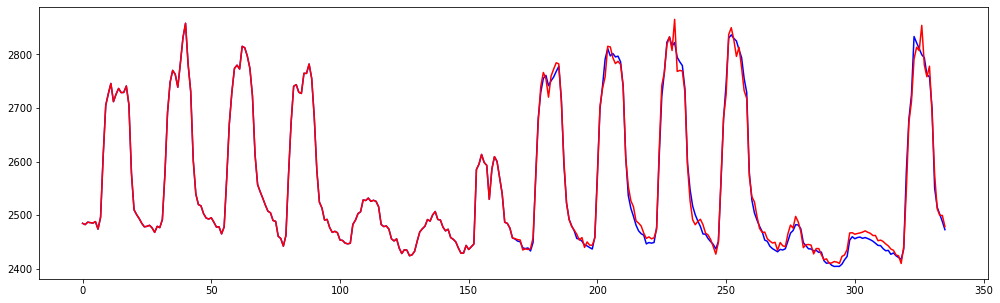

building : 33, score : 0.3693924469180855
now group : D1


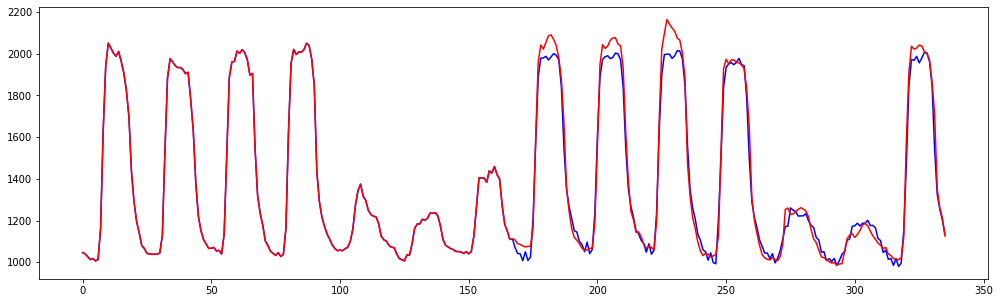

building : 2, score : 2.7617108790555642


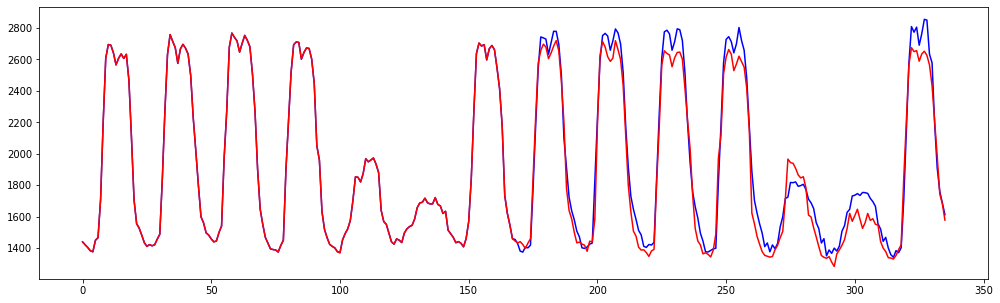

building : 14, score : 4.319050795091279


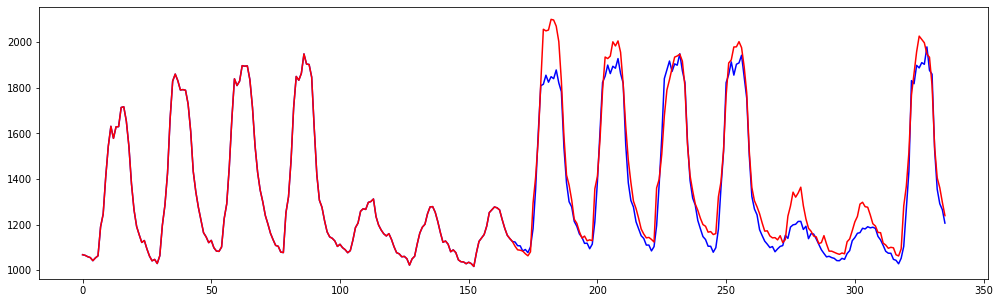

building : 22, score : 4.078382827043716


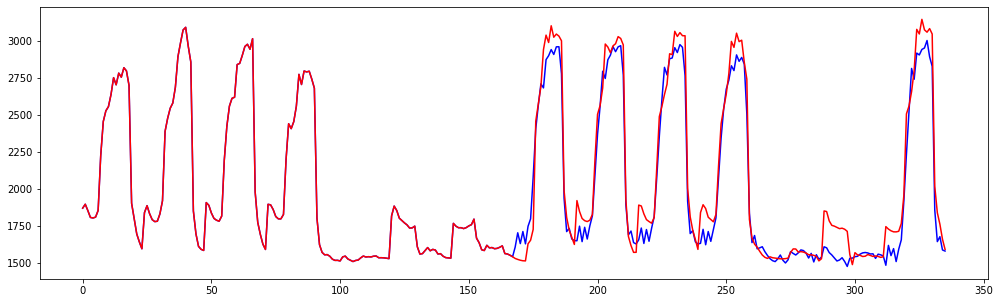

building : 37, score : 4.6065825973573915


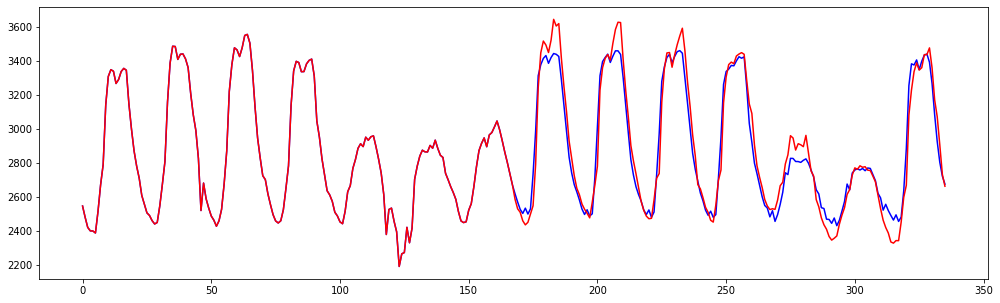

building : 44, score : 2.3612578936680486


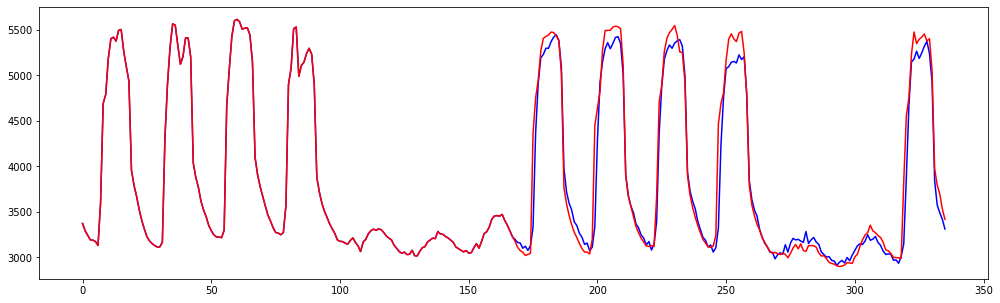

building : 52, score : 2.96169392626084


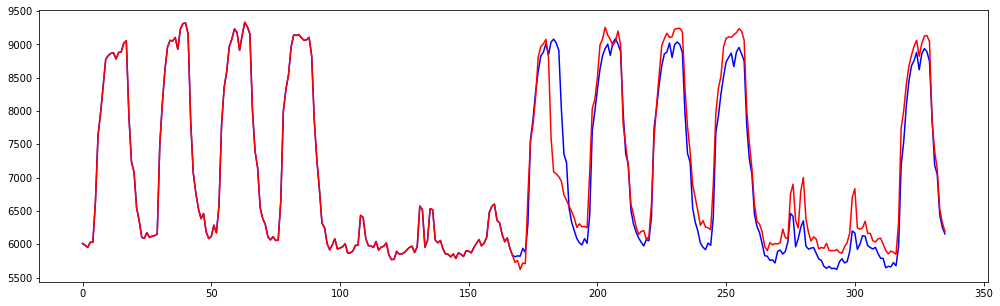

building : 54, score : 3.858805706295618
now group : D2


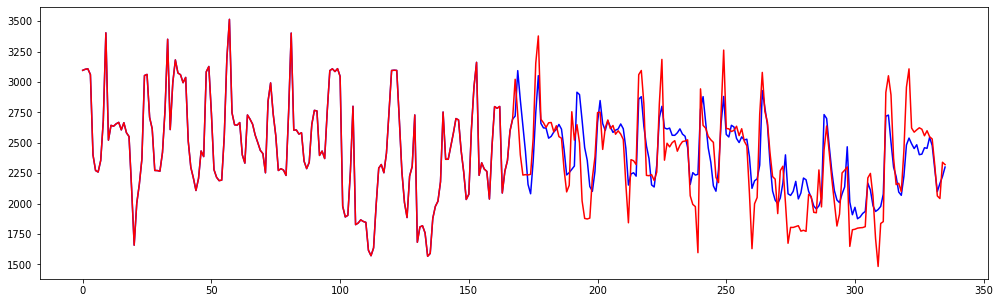

building : 15, score : 7.504922873295248
now group : D3


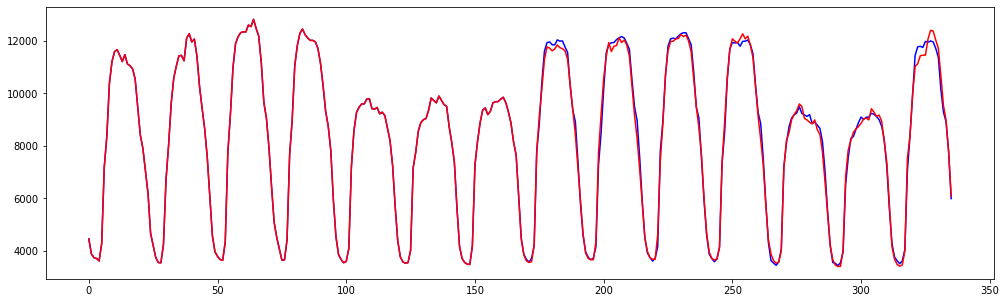

building : 38, score : 2.059139786045466


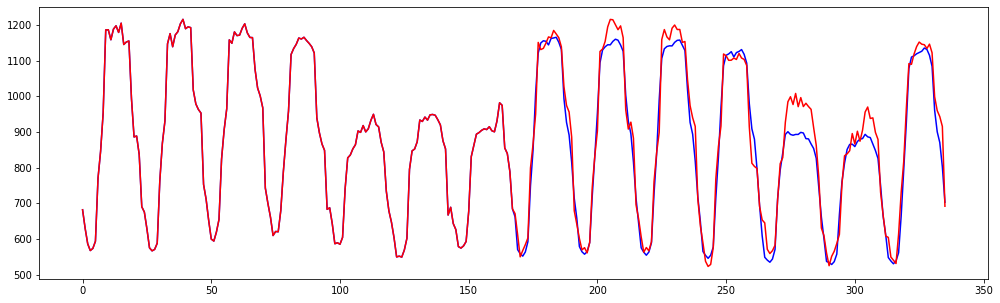

building : 58, score : 3.898490492948076


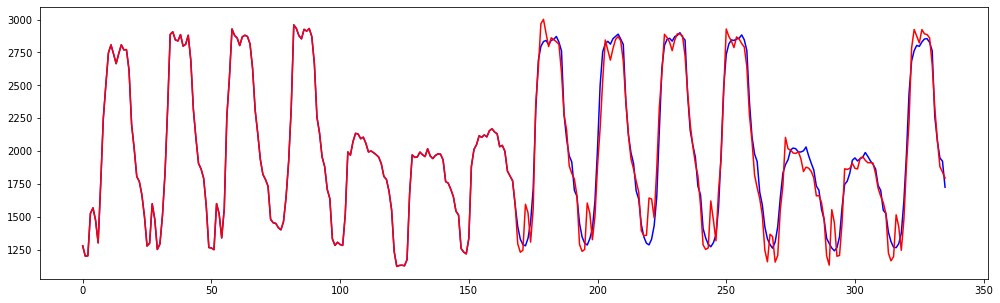

building : 43, score : 5.201691226520912
now group : D4


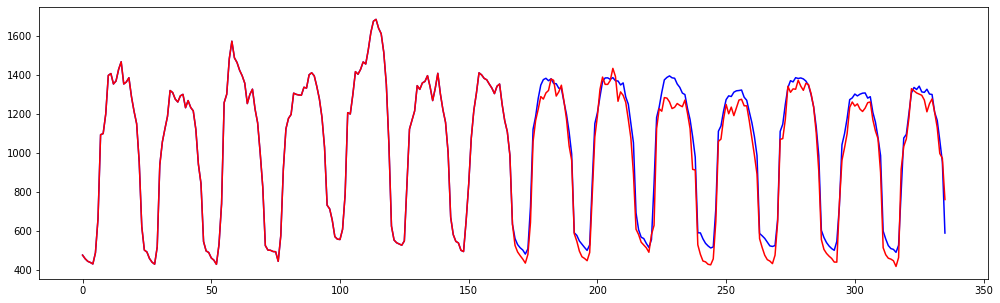

building : 29, score : 6.850481698763763


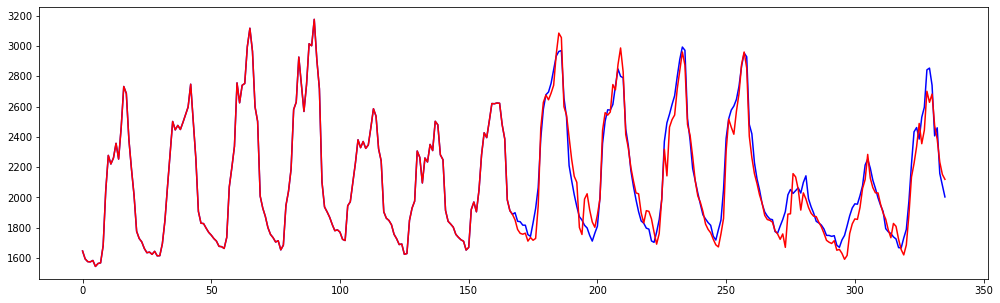

building : 39, score : 3.6102423611249774
now group : D5


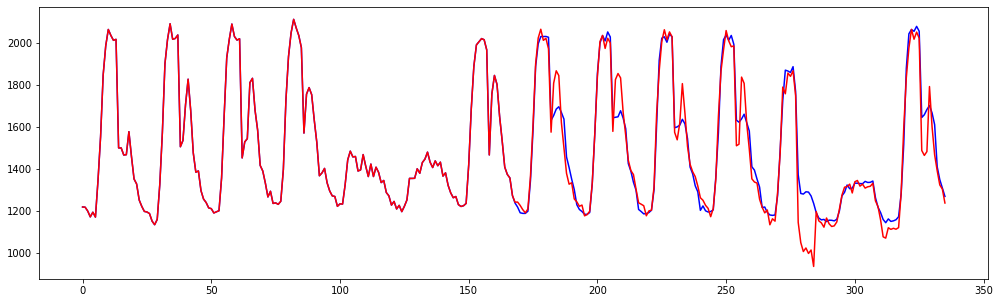

building : 45, score : 3.5396645746602786
now group : D6


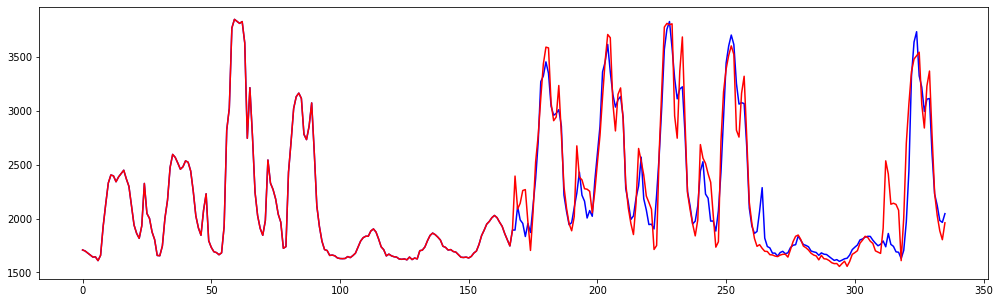

building : 23, score : 6.007564337671204
now group : E1


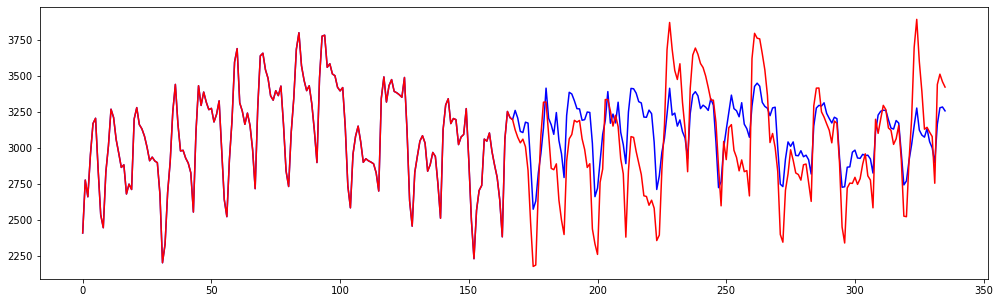

building : 5, score : 7.397015152099009
now group : E2


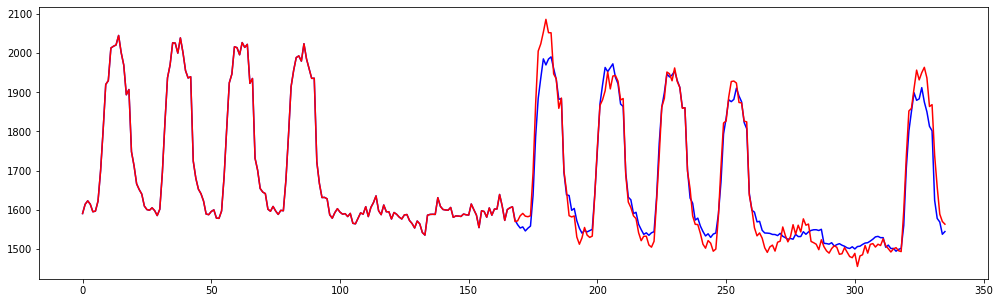

building : 16, score : 1.5005482186536478


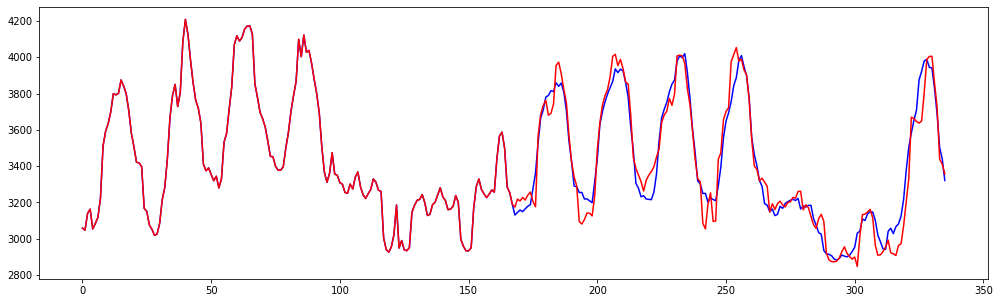

building : 24, score : 1.897137176402071
now group : E3


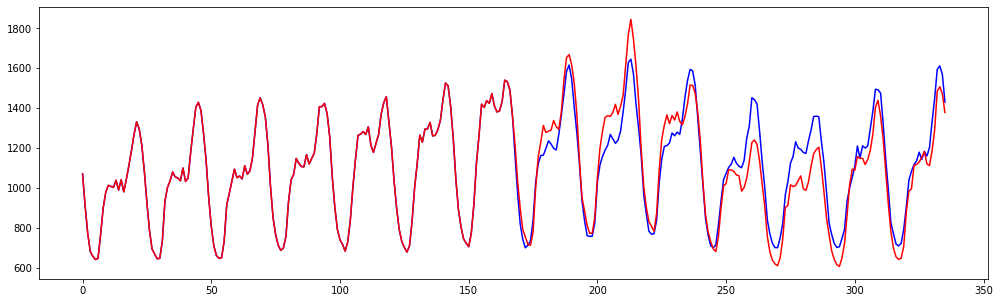

building : 19, score : 7.633642088095523


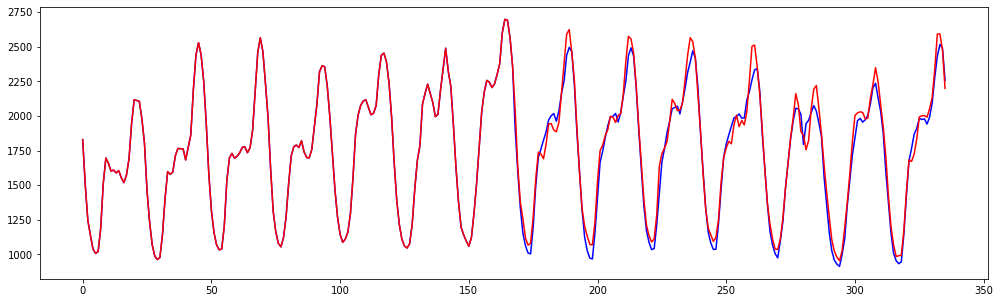

building : 20, score : 3.6372619702804374


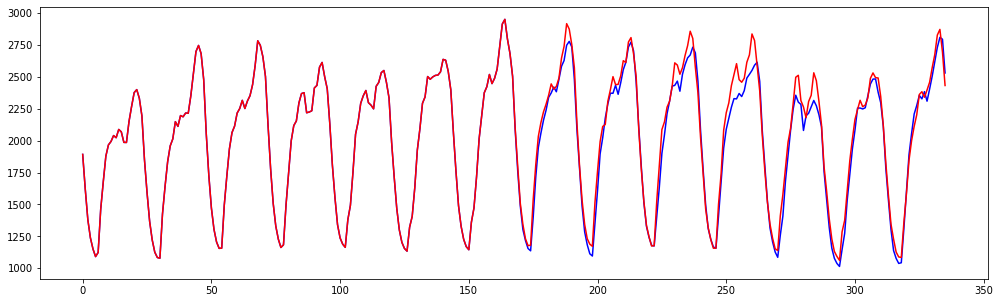

building : 21, score : 3.6351311104471535


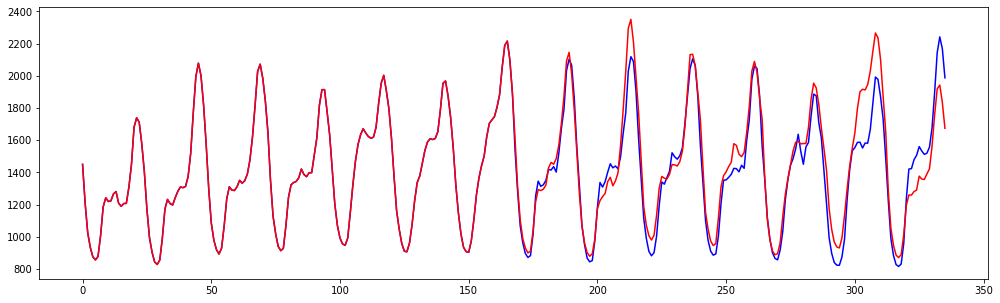

building : 49, score : 6.420452900957282


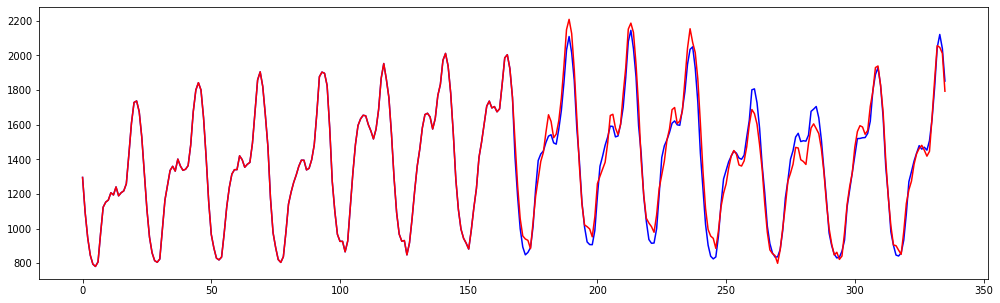

building : 50, score : 3.91930143985219


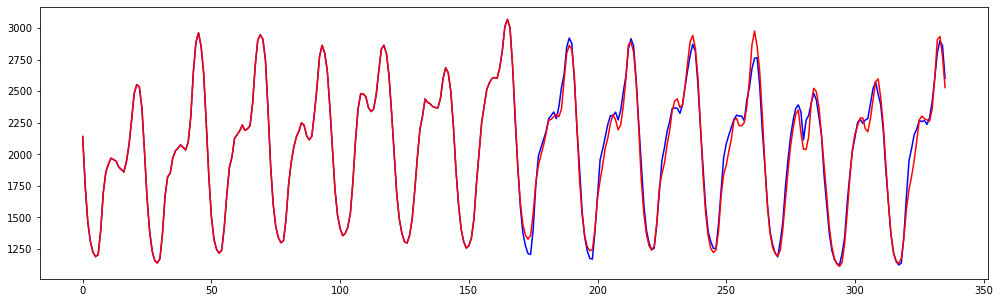

building : 51, score : 3.066406579223044
now group : E4


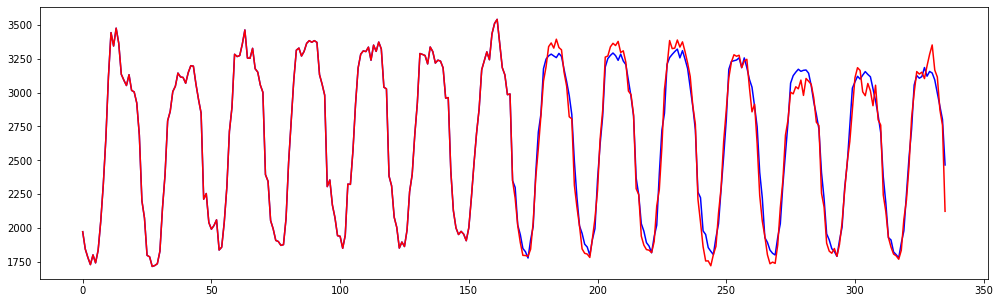

building : 28, score : 2.730526278633793


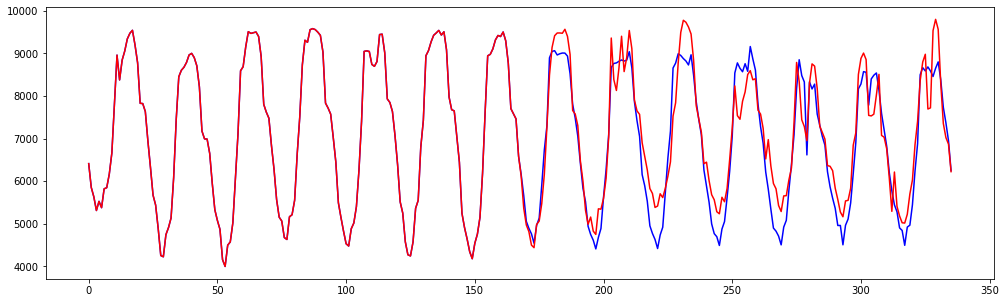

building : 30, score : 6.858495088779804


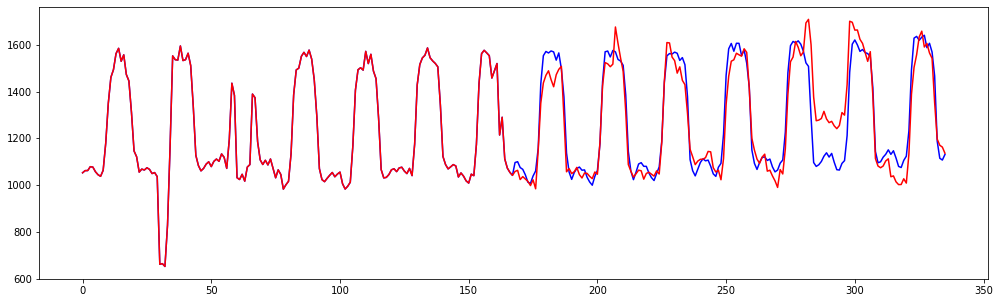

building : 36, score : 4.783539240190736


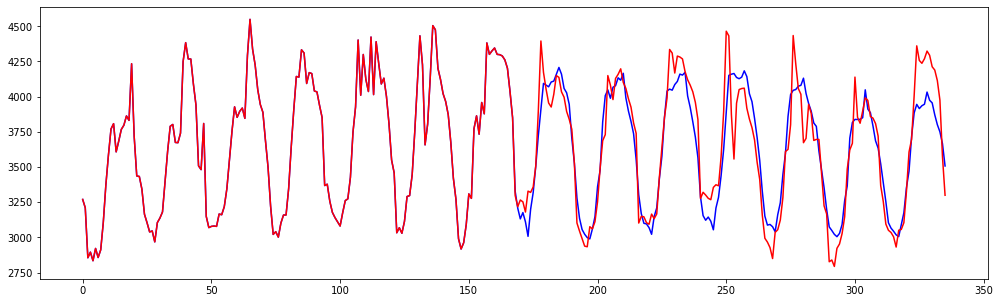

building : 60, score : 3.649732783998192
now group : E5


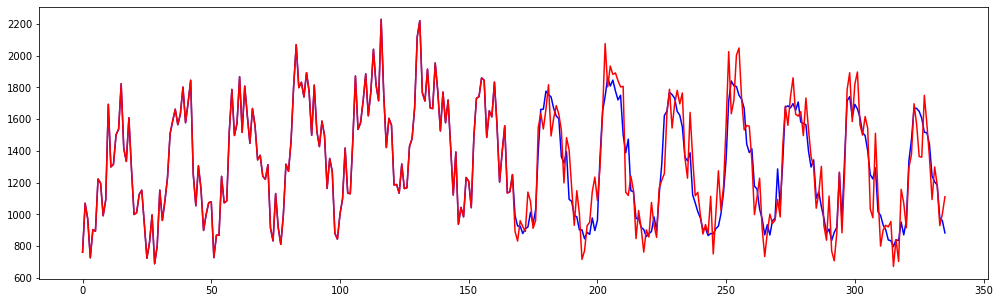

building : 59, score : 9.089276792809121


In [5]:
for i in range(len(model_paths)):
    now_dataframe = dataframes.loc[dataframes["energy_group"] == str(i)].copy()
    
    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    print(f"now group : {group_name[i]}")

    for building in group[i]:
        now_building_dataframe = now_dataframe.loc[now_dataframe["num"] == str(building)].copy()
        now_building_dataframe = now_building_dataframe[start_point:start_point+input_length+duration]

        original = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()
        prediction = now_building_dataframe.iloc[0:input_length]["kWH"].tolist()  

        total_cycle = ((len(now_building_dataframe) - input_length - output_length) // output_length) + 1

        for k in range(total_cycle):
            now_start_point = k*output_length

            encoder_data = now_building_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
            decoder_data = now_building_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
            new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

            raw_predictions = now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
            originals = now_building_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

            prediction.extend(raw_predictions)
            original.extend(originals)

            # for next step, change dataframe's original value to predicted value
            for p in range(output_length):
                now_building_dataframe.iloc[now_start_point+input_length+p, now_building_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
            
        if show_graph:
            plt.rcParams["figure.figsize"] = (17,5)
            fig = plt.figure()
            graph = fig.add_subplot(1, 1, 1)
            graph.plot(prediction, color='blue')
            graph.plot(original, color='red')
            plt.show()

        smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
        print(f"building : {building}, score : {smape_loss}")
        all_smape.append(smape_loss)
        part_smape[i].append(smape_loss)

        # break
    # break

In [6]:
print("\n")
print(f"selected time slice : {random_choice}")
print(f"totoal score : {np.mean(np.array(all_smape))}")
for i in range(len(group_name)):
    print(f"{group_name[i]} score ({len(group[i])}) : {np.mean(np.array(part_smape[i]))}")



selected time slice : 2
totoal score : 4.344752881062069
A1 score (1) : 7.282060999405151
A2 score (2) : 4.538456002501724
A3 score (1) : 2.9296241266611007
A4 score (1) : 5.280621744978951
A5 score (1) : 7.7592858763860235
A6 score (1) : 5.096037184454593
A7 score (1) : 7.4440360662176035
B1 score (9) : 3.406874932919583
B2 score (2) : 6.376434198245693
B3 score (2) : 4.865805495126274
B4 score (3) : 8.774393302019517
B5 score (1) : 1.968324899378457
C1 score (2) : 0.4480776057060566
C2 score (2) : 0.6974117694981516
C3 score (1) : 1.880216278609229
C4 score (1) : 0.3693924469180855
D1 score (7) : 3.563926374967494
D2 score (1) : 7.504922873295248
D3 score (3) : 3.7197738351714844
D4 score (2) : 5.23036202994437
D5 score (1) : 3.5396645746602786
D6 score (1) : 6.007564337671204
E1 score (1) : 7.397015152099009
E2 score (2) : 1.6988426975278594
E3 score (6) : 4.718699348142605
E4 score (4) : 4.505573347900631
E5 score (1) : 9.089276792809121
